In [63]:
#near duplicate detection and elimination
#next steps - obtain more data
#near entity recognition - spacy
#relabeling

# import libraries
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

In [64]:
data_consolidated = pd.read_csv('data_consolidated.csv')

data = pd.DataFrame({'headline':data_consolidated['headline'], 'label':data_consolidated['label']}, columns=['headline', 'label'])

corrections = pd.read_csv('headline_errors.csv')

corrections.columns = ['headline', 'corrected_label']

joined = data.join(corrections.set_index('headline'), on='headline')

notnull = joined[['headline','corrected_label']][joined['corrected_label'].notnull()]

notnull.columns = ['headline','label']

data_path = r'../data/output_data/'

df_union = pd.concat([joined[['headline','label']][joined['corrected_label'].isnull()]
                        ,notnull
                        ,pd.read_csv(data_path + 'apple201907200934.csv')
                        ,pd.read_csv(data_path + 'lg201907200951.csv')
                        ,pd.read_csv(data_path + 'stock_news_201907200922.csv')])

df_union = df_union.astype({'label': 'int64'})


In [65]:
df_union = pd.read_csv('data_consolidated.csv').drop_duplicates()

In [66]:
#this is less balanced now with the addition of new data and new labeling rules
df_union['label'].value_counts()

1    14776
0     3440
Name: label, dtype: int64

In [67]:
import re

df_union['headline'] = df_union['headline'].str.replace("[^a-zA-Z]", " ")

In [68]:
word_count = sum(len(headline.split(' ')) for headline in df_union['headline'])

print(word_count)

292746


In [69]:
from sklearn.model_selection import train_test_split

# split data into training and validation set
df_trn, df_val = train_test_split(df_union[['label','headline']], stratify = df_union['label'], test_size = 0.2, random_state = 12)
print('{}, {}'.format(len(df_trn), len(df_val)))

14572, 3644


In [70]:
unlabeled_headlines = pd.read_csv(r'C:\Users\amber\Documents\VSE\DAEN 690\repo\DAEN-690\data\raw_data\Nowigence Raw Data.csv')

unlabeled_headlines.columns = ['headline']

text_df = pd.DataFrame(df_union['headline'])
text_df['label'] = 0

txt_trn, txt_val = train_test_split(text_df[['label','headline']], stratify = text_df['label'], test_size = 0.2, random_state = 12)

print('{}, {}'.format(len(txt_trn), len(txt_val)))

text_df.head()

14572, 3644


,headline,label
0,google cloud links with stella mccartney to pi...,0
1,America Has Just One Left Hand Drive Mazda RX ...,0
2,amazon prime student get months free echo do...,0
3,google reminds investors that rapid growth isn...,0
4,healthcare cloud computing market amazo...,0


In [71]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = txt_trn, valid_df = txt_val, path = "", num_workers = 0)

# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32, num_workers = 0)

In [72]:
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.7)

In [89]:
print(learn.data.dataset)

LanguageModelPreLoader
dataset: LabelList (14572 items)
x: LMTextList
xxbos ipay is enabling google pay in malaysia video,xxbos live text translation now rolling out to google lens,xxbos mike xxunk s debut feature xxunk has been restored and it s streaming on amazon prime,xxbos sources google is rapidly adding retailers to google express tests showing product recommendations and prices with an option to buy under youtube videos xxunk xxunk information,xxbos this week s top stories pixel a launch google fi financing xxunk android q beta and more to google
y: LMLabelList
,,,,
Path: .
lengths: [ 9 10 17 27 ... 16 26 14 16]
bs: 64
bptt: 70
backwards: False
shuffle: True


In [165]:
#finding a learning rate for the language model
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


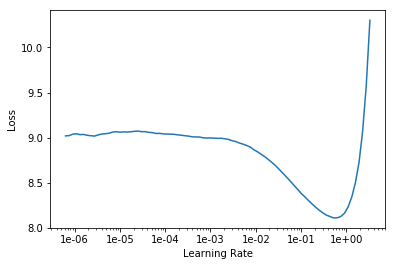

In [166]:
#lowest point is 1, back one magnitude is 0.1 per https://towardsdatascience.com/machine-learning-text-classification-language-modelling-using-fast-ai-b1b334f2872d
learn.recorder.plot()

In [24]:
#adjusting the learning rate based on lr find already improved the results of the first cycle of training
learn.fit_one_cycle(3, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,5.843749,4.855337,0.270998,16:46
1,5.478287,4.756716,0.278954,23:50
2,5.079386,4.630784,0.293575,16:32


In [25]:
#unfreezing and training the whole model
#implementing new practice of saving my model as I go to load prior states as I experiment

learn.save('lm_initial-fine-tuning')

#when I unfreeze I'm am rerunning the lr_find function to see if I get a different result - 
#authors of the text I read adjusted without explanation

learn.unfreeze()
#learn.lr_find()

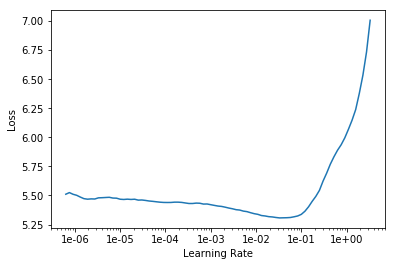

In [169]:
learn.recorder.plot()

In [26]:
#training for one more epoch with the new learning rate after unfreezing the whole model
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.454523,4.283425,0.325000,23:54


In [27]:
learn.save('lm_32500_acc')

In [30]:
#trying out the tensorboard writer and intrinsic attention

#learn.save('lm_train_whole_model_3ep')

learn.predict("stop calling me", 10)


'stop calling me from after controversy storm started xxbos The Zacks'

In [ ]:
#I probably don't need to import all of these...I'll do more research to figure out just what I'm using below

from fastai.torch_core import *
from fastai.callback import *
from fastai.layers import *
from fastai.basic_train import LearnerCallback

#based on fastai's built in fbeta and accuracy metrics - the fbeta that is built in only works on one hot encoded multiclass targets

def fscore(y_pred:Tensor, y_true:Tensor, thresh:float=0.2, beta:float=1, eps:float=1e-9, sigmoid:bool=True)->Rank0Tensor:
    "Computes the f_beta between `preds` and `targets`"
    beta2 = beta ** 2
    n = y_true.shape[0]
    if sigmoid: y_pred = y_pred.sigmoid()
    y_pred = y_pred.argmax(dim=-1).view(n,-1)
    y_true = y_true.view(n,-1)
    TP = (y_pred*y_true).float().sum()
    prec = TP/(y_pred.float().sum()+eps)
    rec = TP/(y_true.float().sum()+eps)
    res = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)
    return res.float().mean()

In [31]:
#not using my fscore, doesn't change model behavior but does prevent the model from being easily transferable

#from fastai import metrics

learn.save_encoder('ft_enc')
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc')
#learn.load('ulmfit_export')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


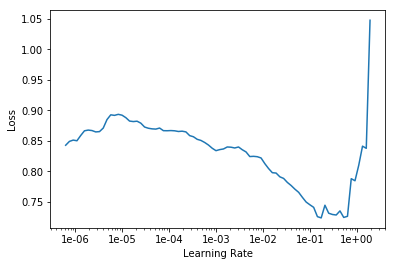

In [175]:
learn.lr_find()
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(1, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.354615,0.310736,0.880077,11:19


In [33]:
#start here
learn.save('tc_1_ep')
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.345667,0.278946,0.895993,25:28


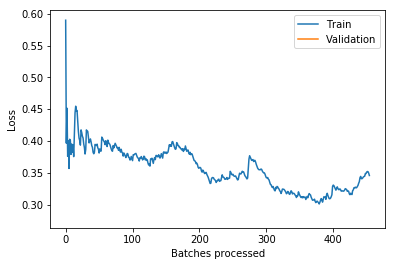

In [34]:
learn.save('tc_2_ep')
learn.recorder.plot_losses()

In [35]:
learn.save('tc_2_ep')
learn.freeze_to(-2)
learn.fit_one_cycle(2, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.322732,0.258092,0.899835,15:45
1,0.279880,0.246172,0.903403,14:04


In [36]:
learn.save('tc_4_ep')
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.298307,0.249713,0.905324,23:41


In [37]:
learn.save('tc_5_ep')
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.270833,0.296076,0.903952,23:52


In [38]:
#5 tc_5_ep valid_loss > train_loss accuracy decline
learn.load('tc_4_ep')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (14572 items)
x: TextList
xxbos apple watch gets a rare fall on amazon,xxbos google pixel just xxunk its biggest obstacle cnet,xxbos xxmaj scouted xxmaj amazon s xxmaj day xxmaj long xxmaj sale xxmaj gets xxmaj you xxmaj up to xxmaj off xxmaj top xxmaj rated xxmaj running xxmaj shoes xxmaj from xxmaj xxunk adidas xxup puma and xxmaj more,xxbos amazon is xxunk the apple watch series by for a limited time and it s one of the best deals we ve seen on the smartwatch yet,xxbos save big with amazon coupon codes may nd
y: CategoryList
1,1,0,1,1
Path: .;

Valid: LabelList (3644 items)
x: TextList
xxbos hyundai blue link enhanced with google assistant voice command features xxunk,xxbos google raises concerns about singapore s fake news law,xxbos law enforcement xxunk for google data,xxbos a list of common questions people google about cinco de mayo,xxbos google works and one method for direct translation of language
y: CategoryList
1,1,1,1,1


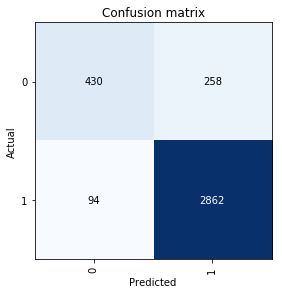

In [39]:
txt_ci = TextClassificationInterpretation.from_learner(learn)
txt_ci.plot_confusion_matrix()

In [40]:
predictions = learn.get_preds()

In [41]:
df = pd.DataFrame([i.tolist() for i in predictions[0]])
df['target'] = [i for i in predictions[1].tolist()]
df.columns = ['0','1','target']
df.head()

,0,1,target
0,0.277966,0.722034,1
1,0.237382,0.762618,0
2,0.327109,0.672891,0
3,0.203534,0.796466,0
4,0.003698,0.996302,1


In [43]:
df['predictions'] = [1 if row[0] < row[1] else 0 for i,row in df[['0','1']].iterrows()]
df.head(10)

,0,1,target,predictions
0,0.277966,0.722034,1,1
1,0.237382,0.762618,0,1
2,0.327109,0.672891,0,1
3,0.203534,0.796466,0,1
4,0.003698,0.996302,1,1
5,0.003107,0.996893,1,1
6,0.000435,0.999565,1,1
7,0.162261,0.837739,1,1
8,0.115403,0.884597,1,1
9,0.115266,0.884734,1,1


In [45]:
from sklearn import metrics
# Predicting with a test dataset

# Model Accuracy
print("ULMFiT Accuracy:",metrics.accuracy_score(df['target'], df['predictions']))
print("ULMFiT Precision:",metrics.precision_score(df['target'], df['predictions']))
print("ULMFiT Recall:",metrics.recall_score(df['target'], df['predictions']))
print("ULMFiT f1:",metrics.f1_score(df['target'], df['predictions']))

ULMFiT Accuracy: 0.9034028540065862
ULMFiT Precision: 0.9173076923076923
ULMFiT Recall: 0.9682002706359946
ULMFiT f1: 0.9420671494404214


In [46]:
learn.predict("Gambling Stock Roundup: WYNN to Sell Massachusetts Casino, DIS &amp; CZR Ink Deal")

C:\ProgramData\Anaconda3\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category 0, tensor(0), tensor([0.9085, 0.0915]))

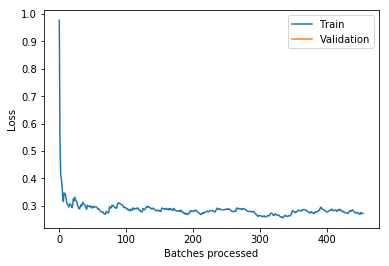

In [56]:
learn.recorder.plot_losses()

In [57]:
import warnings
warnings.filterwarnings('ignore')

error_analysis = pd.DataFrame(pd.read_csv(r'C:\Users\amber\Documents\VSE\DAEN 690\repo\DAEN-690\data\output_data\error_analysis.csv'))
error_analysis.head()

ulmfit_preds = error_analysis['headline'].apply(lambda row: str(learn.predict(row)[0]))

print(ulmfit_preds[:5])
#learn.predict("This was a great movie!")

0    1
1    1
2    1
3    1
4    1
Name: headline, dtype: object


In [58]:
error_analysis['ulmfit_classification'] = ulmfit_preds

error_analysis.head()

,Unnamed: 0,headline,actual_classification,ulmfit_classification
0,0,what's new on netflix hulu amazon and hbo this...,0,1
1,1,"Samsung TVs, HP monitors, Morphy Richards slow...",0,1
2,2,amazon 1day shipping lifts startups serving wa...,0,1
3,3,Imagine Owning Apple Hospitality REIT (NYSE:AP...,0,1
4,4,"Corteva Agriscience Set to Incorporate DuPont,...",0,1


In [59]:
error_analysis[['headline','actual_classification','ulmfit_classification']][error_analysis.actual_classification != error_analysis.ulmfit_classification].to_csv(r"C:\Users\amber\Documents\VSE\DAEN 690\repo\DAEN-690\data\output_data\error_analysis.csv")

learn.export('models/final_model.pkl')